# Sentiment Analysis for Movie Reviews

**Outline**

* [Introduction](#intro)
* [Dataset](#data)
* [NLP Process](#process)
* [Some Further Explaination](#explain)
    * [N-gram Model](#ngram)
    * [TF-IDF](#tfidf)
* [Sentiment Analysis Implementation](#implement)
    * Unigrams (absence/presence)
    * Unigrams with frequency count
    * Unigrams (only adjectives/adverbs)
    * Unigrams (sublinear tf-idf)
    * Bigrams (absence/presence)
    * [Other function to do text preprocessing](#other_function)
    * [Conclusion](#conclusion)    
* [Reference](#refer)

---

In [81]:
%reload_ext watermark

import pandas as pd
import numpy as np
import string, re, os
from nltk import pos_tag
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import math
%matplotlib inline  

%watermark -a 'Johnny' -d -t -v -p pandas,numpy,nltk,sklearn,seaborn

Johnny 2018-12-26 00:45:15 

CPython 3.6.3
IPython 6.1.0

pandas 0.20.3
numpy 1.13.3
nltk 3.2.4
sklearn 0.19.1
seaborn 0.8.0


---

## <a id='intro'>Introduction</a>

Sentiment Analysis is a very popular text analytics application. Here, we are going to use sentiment anaylsis that automatlically classifies the sentiment of a movie review as either positive or negative. 

Similar to from the [previous post about Näive Bayes](http://nbviewer.jupyter.org/github/johnnychiuchiu/Machine-Learning/blob/master/NaiveBayes/naiveBayesTextClassification.ipynb), we'll also use Näive Bayes. The idea and topic we want to focus more in this post, however, is to experiment with several ways to do text pre-processing before fitting Näive Bayes model. Some of the [ideas](http://nbviewer.jupyter.org/github/johnnychiuchiu/Machine-Learning/blob/master/NaiveBayes/naiveBayesTextClassification.ipynb#improve) were also mentioned in the previous post, 

In this post, while doing an end-to-end sentiment anaylsis, we want to focus more on different ways to do text preprocessing and why we choose a particular way to do it (i.e., pros and cons), with the goal of having a better classification outcome. 

Some of the topics includes
* Text Preprocessing
    * Keep capitalization or not
    * Removing punctuation or not
    * Removing stopwords or not
    * Different ways to do Tokenization 
    * Stemming / Lemmatization    
* Part of Speech (POS) Tagging
* N-gram
* TF-IDF

## <a id='dataset'>Data Set</a>

The dataset used in this project is the [polarity dataset v2.0 (3.0Mb, click to download)](http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz): 1000 positive and 1000 negative movie reviews. Introduced in Pang/Lee ACL 2004 and released June 2004, it is drawn from an archive of the rec.arts.movies.reviews newsgroup hosted at IMDB.

In this post, we divide the corpus with a ratio 90:10 split for training and testing (200 review files are used as test – i.e., files that start with cv9) and we keep an even distribution of positive and negative labels. 

In [2]:
def read_data(filepath, review_type):    
    """This funtion reads in the data, parses it, and separates it into 
    the appropriate train and test splits. Data is read in in UTF-8, and is
    parsed by removing all punctuation. Any review that begins with the 
    filename 'cv9' is considered to be part of the test set.
    
    Args:
        filepath: path to the corpus
        review_type: type of review included in the data within this filepath
    Returns:
        Returns four separate lists. The test set corpus, the test set labels,
        the training set corpus, and the training set labels. 
        
    The function is copied from here (https://github.com/spalmerg/Sentiment-Analysis/blob/master/Sentiment%20Analysis.ipynb)    
    """
    test, test_labels = [], []
    train, train_labels = [], []
    
    for filename in os.listdir(filepath):
        with open(filepath + filename, 'rb') as review:
            txt = review.read().decode('utf8', 'surrogateescape')
            txt = txt.replace("--", "").replace("_", " ").replace("-", " ")
            translator = str.maketrans('', '', string.punctuation)
            txt = txt.translate(translator)
            txt = txt.split()
            txt = ' '.join(txt)
            if filename.startswith('cv9'):
                test.append(txt)
                test_labels.append(review_type)
            else: 
                train.append(txt)
                train_labels.append(review_type)
    return(test, test_labels, train, train_labels)

In [3]:
# read in positive and negative reviews
neg_test, neg_test_labels, neg_train, neg_train_labels = read_data('review_polarity/txt_sentoken/neg/', 'Negative')
pos_test, pos_test_labels, pos_train, pos_train_labels = read_data('review_polarity/txt_sentoken/pos/', 'Positive')

# combine training sets
train_labels = neg_train_labels + pos_train_labels
train = neg_train + pos_train

# combine test sets
test_labels = neg_test_labels + pos_test_labels
test = neg_test + pos_test

> **First look at the dataset**

**An exmaple of a positive review**: everyone loves the movie *You've got mail*, including the person who wrote this review

In [12]:
print(pos_train[2])

youve got mail works alot better than it deserves to in order to make the film a success all they had to do was cast two extremely popular and attractive stars have them share the screen for about two hours and then collect the profits no real acting was involved and there is not an original or inventive bone in its body its basically a complete re shoot of the shop around the corner only adding a few modern twists essentially it goes against and defies all concepts of good contemporary filmmaking its overly sentimental and at times terribly mushy not to mention very manipulative but oh how enjoyable that manipulation is but there must be something other than the casting and manipulation that makes the movie work as well as it does because i absolutely hated the previous ryanhanks teaming sleepless in seattle it couldnt have been the directing because both films were helmed by the same woman i havent quite yet figured out what i liked so much about youve got mail but then again is that

**An exmaple of a negative review**: we can tell this guy didn't like the movie at all just based on the first sentence

In [13]:
neg_train[7]

'thats exactly how long the movie felt to me there werent even nine laughs in nine months its a terrible mess of a movie starring a terrible mess of a man mr hugh grant a huge dork its not the whole oral sexprostitution thing referring to grant not me that bugs me its the fact that grant is annoying not just adam sandler annoying were talking jim carrey annoying since when do eye flutters and nervous smiles pass for acting but on the other hand since when do really bad slapstick a fistfight in the delivery room culminating in grants head in joan cusacks lapa scene he paid 60 to have included in the movie and obscene double entendres robin williams the obstetrician tells grants pregnant girlfriend she has a big pussy referring of course to the size of the cat hairs on her coat but nonetheless grant paid 60 to have the exchange included in the movie pass for comedy nine months is a predictable cookie cutter movie with no originality in humor or plot hugh grant plays a successful child ps

**Summary Statistics**: These reviews seems to be more serious and much more lengthy then I thought before checking them. Let's also take a look at some of the statistics about review length. We can see from below that the average length of these reviews are ~3600 characters, with the longest one of 14k; shortest one with only 86 characters. Overall, we can also see that positive reviews are generally longer (based on median), which would be different from product reviews, where people would tend to write longer reviews if they hate it.

count     1800.000000
mean      3631.452222
std       1605.006488
min         86.000000
25%       2551.500000
50%       3397.500000
75%       4372.500000
max      14174.000000
Name: Review Length, dtype: float64


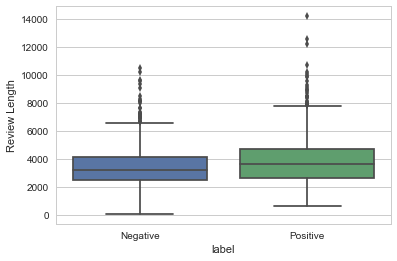

In [24]:
# get the document length
neg_train_length = [len(i) for i in neg_train]
pos_train_length = [len(i) for i in pos_train]

# make it into a dataframe
doc_length_df = pd.DataFrame(neg_train_length+pos_train_length, columns=['Review Length'])
doc_length_df['label'] = ['Negative']*900 + ['Positive']*900
doc_length_df.head()
print(doc_length_df['Review Length'].describe())

sns.set(style="whitegrid")
ax = sns.boxplot(x="label", y='Review Length', data=doc_length_df)
ax

## <a id='process'>NLP Process</a>

1. **Read Text Files**
2. **Transformation: Tokenization** 
    * splitting a string into its desired constituent parts; an indispensable component in almost any NLP application.
    * This is a very important process in sentiment analysis. Sentiment information is often sparsely and unusually represented; E.g.: a single cluster of punctuation like :-) might tell the whole story.
    * careful tokenization pays-off, especially where there is relatively little training data available; for a lot of data: less important (enough data for the model to learn that, e.g., happy and happy, are basically both the same token).
    * Some commonly used strategies includes:
        * **Whitespace tokenization**: obtain each token by whitespace, where a token is the smallest unit when doing text analytics, can be a number, punctuation, or a word
        * **Treebank-style tokenization**: this approach would usually result in more units than whitespace tokenization since almost all tokens that involve punctuation are split apart — URLs, Twitter mark-up, phone numbers, dates, email addresses ... Thus, emoticons are collapsed with their component parts, URLs are not constituents, and Twitter mark-up is lost.
        * **Sentiment-aware tokenization**: how to implement this would be on case-by-case basis. Some rules for twitter for example, would be 
            * not to separate twitter handle even it includes punctuation mark
            * letters at the edges (\*\*\*\*, s\*\*\*t), which is good to treat them as tokens
            * keep Lenghtening by character repetition (it was sooooo good!)
3. **Transformation- Stemming/Lemmatization**: a method for identifying distinct word forms (for reduction of vocabulary size). Stemming/lemmatization could help with sentiment analysis, in theory. **Stemming** usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. **Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . If confronted with the token saw, stemming might return just s, whereas lemmatization would attempt to return either see or saw depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma
    * Example:
        * Stemming: happy, happier, happiest -> happ
        * Lemmatizing: happy, happier, happiest -> happy
    * Note:
        * In practice, these off-the-shelf stemming algorithms can weaken sentiment systems.
        * Which stemmer or lemmatization to use is often times trial and error.
    * Available Stemmers:
        * [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/)
            * Problem: collapses sentiment distinctions, by mapping two words with different sentiment into the same stemmed form;
            * E.g.: captivation (pos); captive (neg); both become -> captiv
        * [Lancaster Stemmer](http://www.lancaster.ac.uk/scc/)
            * it is arguably even more problematic than the Porter stemmer, since it collapses even more words of differing sentiment.
            * E.g.: meaningful (pos); mean(neg); both become -> mean
        * [WordNet Lemmatizer](https://www.nltk.org/_modules/nltk/stem/wordnet.html)
            * high-precision stemming functionality; it requires (word, part-of-speech tag) pairs; 
            * Problem: it collapses tense, aspect, and number marking. E.g.: (exclaims, v)  exclaim 
4. **Transformation: others** 
    * Converting to lower case
    * Removing punctuation
    * Removing numbers
    * Removing stopwords
    * Removing tokens based on tf-idf (for example, remove words that occurred in less than 5 documents and those that occurred in more than 80% of documents.)
    * Tagging and keeping only some type of part-of-speech (nouns, verbs, adjectives, etc.) or entity recognition (person, place, company, etc.)
5. **Vectorization**: 
    * N-grams: Unigrams vs Bigrams
    * Frequency Count vs absence/presence
6. **Fit Näive Bayes model**

## <a id='explain'>Some Further Explaination</a>

### <a id='ngram'>N-gram Model</a>

> **What is N-gram? N-gram Model?**

$\text{Please turn your homework ..}$

How do we, if we ever need to guess, know what is the word that will most likely to show up next? If we have a large enough document or corpus (a collection of documents), we can probably know it by calculating conditional probabilities for the following words such as

$$P(in|Please turn your homework)$$

$$P(out|Please turn your homework)$$

$$P(on|Please turn your homework)$$

$$\dots$$

Then the word having the largest probability would be the word that is most likely to show up next. This is the essential idea of N-gram Model. In our case, the N-gram (an n-gram is a contiguous sequence of n items from a given sample of text or speech) we use for this language modeling is four-gram. Of course, we can also use unigram, bigram, trigram, ...etc

Models that assign probabilities to sequences of words are called **language model**. When we use N-gram for language modeling, independence assumptions are made so that each word depends only on the last n − 1 words. This assumption is important because it massively simplifies the problem of estimating the language model from data. In addition, because of the open nature of language, it is common to group words unknown to the language model together.

> **Example**

The picture below is copied from [Speech and Language Processing Chap 3: N-grams](https://web.stanford.edu/~jurafsky/slp3/3.pdf), which demos how to estimate bigram probabilities

**Example 1**

The count of each word is the number of document (in this case, a sentence is a document) is obtained by counting number of sentences having that word (not the total number of the word, even though in our case both turn out to be the same). For example, there are 3 sentence having the word `I`, which is the same as the total occurence of `I`.

<img src="pic/bigram1.png" style="width: 500px;height: 180px;"/>

**Example 2**

Here, what we see is some summary statistics from a sample of 9332 sentences of the now-defunct Berkeley Restaurant Project, a dialogue system from the last century that answered questions about a database of restaurants in Berkeley, California. 

Figure 3.1 shows the bigram counts from a piece of a bigram grammar from the Berkeley Restaurant Project. Note that the majority of the values are zero. In fact, we have chosen the sample words to cohere with each other; a matrix selected from a random set of seven words would be even more sparse.
Figure 3.2 shows the bigram probabilities after normalization using unigram count for these selected words.

<img src="pic/bigram2-1.png" style="width: 400px;height: 50px;"/>

<img src="pic/bigram2-2.png" style="width: 400px;height: 300px;"/>

> **Application**

* **Language Identification**: given a text, output the langugage used. Of course, we would need to have training probability for different language first.
* **Spelling Correction**: when the probability of a certain N-gram is too low comparing to the training probability from a very large corpus, then it is likely that that particular term is a type. For example, The probabilty of $P(their|are)$, i.e., "their are", would be very low.
* **Word Breaking**: breaking a sentence into smaller pieces based on the N-gram probability. Identifying collocation using [Pointwise Mutual Information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) is something related.
* **Text Summarization**: Here is a paper that uses Web N-gram models for text summarization: [Micropinion Generation: An Unsupervised Approach to Generating Ultra-Concise Summaries of Opinions](http://kavita-ganesan.com/micropinion-generation/#.XCRTjs9Kh0s)
* **Machine Translation**: 
    * For example, as part of the machine translation process we might have built the following set of potential rough whatever-language to English translations:
        * he introduced reporters to the main contents of the statement
        * he briefed to reporters the main contents of the statement
        * **he briefed reporters on the main contents of the statement**
    * A probabilistic model of word sequences could suggest that *briefed reporters* on is a more probable English phrase than *briefed to reporters* (which has an awkward to after briefed) or *introduced reporters to* (which uses a verb that is less fluent English in this context), allowing us to correctly select the boldfaced sentence above.
* **Augmentative Communication**: Probabilities are also important for augmentative communication (Newell et al.,
1998) systems. People like the late physicist Stephen Hawking who are unable to physically talk or sign can instead use simple movements to select words from a menu to be spoken by the system. Word prediction can be used to suggest likely words for the menu. (the paragraph is copied from [Speech and Language Processing Chap 3: N-grams](https://web.stanford.edu/~jurafsky/slp3/3.pdf))


> **N-gram Model vs Näive Bayes**

To my understanding, usually a Näive Bayes model refer to a unigram language model. Essentially they are the same. Independence assumptions are made so that the probability of the sentence of belonging to a certain class depends only on the probability product of the words in the sentence. 

On a high level, Näive Bayes can be seen as a special case of N-gram Modeling. Näive Bayes can be used only for text classification whereas N-gram modeling can be used for many different applications includeing those introduce above.

> **Implementation**

Here we would like to provide an example of how to implemment N-gram from scratch for **Language Identification**. Here is the description:

```
Language Identification, which is the problem of taking as input a text in an unknown language and determine what language it is written in. N-gram models are very effective solutions for this problem as well.

For training, use the English, French, and Italian texts made available (see the Assignment2 folder). For test, use the file LangId.test provided in the language_identification folder as well. For each of the following questions, the output of your program has to contain a list of 
[line_id] [language] pairs, starting with line 1. For instance,

   1 English
   2 Italian
   ...
```

The following codes are the implementation of N-gram using **Add-one Smoothing** and **Good-Turing Smoothing**, both are ways to allocation probabilities to unknown words.

In [121]:
"""
Author: Johnny Chiu, Master of Science in Analytics
Goal: 
Implement a word bigram model using add-one smoothing, which learns word bigram probabilities from the training data.
Then apply the models to determine the most likely language for each sentence in the test file.
"""
import pandas as pd
import numpy as np

class Q2():
    def read_files(self):
        """read English, French, and Italian training text; also lower case them"""
        
        f = open('language_identification/LangId.train.English', 'rb')
        train_english = f.read().decode('utf8', 'backslashreplace')
        f.close()

        f = open('language_identification/LangId.train.French', 'rb')
        train_french = f.read().decode('utf8', 'backslashreplace')
        f.close()

        f = open('language_identification/LangId.train.Italian', 'rb')
        train_italian = f.read().decode('utf8', 'backslashreplace')
        f.close()

        return {'english': train_english.lower(), 'french': train_french.lower(),'italian': train_italian.lower()}      
    
    def get_sentence_probability(self, term_dict, unigram_language, bigram_language):
        """calculate the probability according to the input sentence and language using 2-gram

        Args:
            term_dict(dict): contains bigram count of a sentence
            unigram_language(dict): contains unigram count of the training data in a specific language
            bigram_language(dict): contains bigram count of the training data in a specific language

        Return:
            the probability of this input dict is a certain language
        """

        # set initial value and get total vocabulary size for smoothing
        log_sum = 0
        V = len(set(unigram_language.keys()))+1

        # get what the overall probability is for each sentence using add-one smoothing to estimate the bigram probability
        for i in list(term_dict.keys()):
            if i in bigram_language.keys():
                denominator = unigram_language[i.split(" ")[0]]+V # plus V for add-one smoothing
                nominator = bigram_language[i]+1 # plus 1 for add-one smoothing
                prob = float(nominator)/denominator
                log_sum += np.log(prob) * term_dict[i]
            else:
                unigram_count = unigram_language[i.split(" ")[0]] if i.split(" ")[0] in unigram_language.keys() else 0
                prob = 1/(unigram_count+V)
                log_sum += np.log(prob) * term_dict[i]

        return(np.exp(log_sum))
    
    def identify_language(self, term_dict):
        """identify what the language is for the input text"""
    
        prob_list = [self.get_sentence_probability(term_dict, unigram_english, bigram_english), 
                     self.get_sentence_probability(term_dict, unigram_french, bigram_french), 
                     self.get_sentence_probability(term_dict, unigram_italian, bigram_italian)]
        top_index = prob_list.index(max(prob_list))

        if top_index == 0:
            language = 'English'
        elif top_index == 1:
            language = 'French'
        elif top_index == 2:
            language = 'Italian'
        else:
            language = 'Others'

        return(language)
    
    def get_language_all_sentence(self, test):
        """identify language used per sentence for the input text

        Args:
            test(list of lists): each item in the list is a string in a sentence

        Return:
            a dataframe with [id, language]
        """

        # identify language used per sentence
        language_list = []
        n=2
        for s in test:
            bigram_in_test_sentence = [' '.join(s[i : i + n]) for i in range(len(s)-n+1)]
            bigram_dict = {c: bigram_in_test_sentence.count(c) for c in set(bigram_in_test_sentence)}                
            language = self.identify_language(bigram_dict)
            language_list.append(language)

        final_df = pd.DataFrame({'id': list(range(1,len(test)+1)),
                                'identified_language': language_list})

        return(final_df)


if __name__=='__main__':
    q2 = Q2()
    
    ### 1. Read Files (English, Italian, French)
    train = q2.read_files()
  
    ### 2. Train Transformation: separate into words by space
    # list of lists, each item in the list is a single word
    train_english = [s.split(" ") for s in train['english'].splitlines()]
    train_french = [s.split(" ") for s in train['french'].splitlines()]
    train_italian = [s.split(" ") for s in train['italian'].splitlines()]
    
    # list containing every single word
    word_english = [item for sublist in train_english for item in sublist]
    word_french = [item for sublist in train_french for item in sublist]
    word_italian = [item for sublist in train_italian for item in sublist]
    
    ### 3. Get the unigram count for each language as dict (counting number of sentences having that word)
    unigram_english = {w: sum(w in sentence for sentence in train_english) for w in set(word_english)}
    unigram_french = {w: sum(w in sentence for sentence in train_french) for w in set(word_french)}
    unigram_italian = {w: sum(w in sentence for sentence in train_italian) for w in set(word_italian)}
        
    ### 4. Get the bigram count for each language as dict, separating by space.
    # list of lists, with each item represent bigram within each sentence
    n=2
    train_bigram_english = [[' '.join(sentence[i : i + n]) for i in range(len(sentence)-n+1)] for sentence in train_english]
    train_bigram_french = [[' '.join(sentence[i : i + n]) for i in range(len(sentence)-n+1)] for sentence in train_french]
    train_bigram_italian = [[' '.join(sentence[i : i + n]) for i in range(len(sentence)-n+1)] for sentence in train_italian]
    
    # list containing every bigram
    word_2_english = [item for sublist in train_bigram_english for item in sublist]
    word_2_french = [item for sublist in train_bigram_french for item in sublist]
    word_2_italian = [item for sublist in train_bigram_italian for item in sublist]
    
    # dictionary containing the bigram count in each sentence
    bigram_english = {w: sum(w in sentence for sentence in train_bigram_english) for w in set(word_2_english)}
    bigram_french = {w: sum(w in sentence for sentence in train_bigram_french) for w in set(word_2_french)}
    bigram_italian = {w: sum(w in sentence for sentence in train_bigram_italian) for w in set(word_2_italian)}
              
    ### 5. Take test file as input, separate into sentence
    f = open('language_identification/LangId.test', 'rb')
    test_original = f.read().decode('utf8', 'backslashreplace').lower()
    test = [s.split(" ") for s in test_original.splitlines()]
    f.close()

    ### 6. Identify language used per sentence for the input text
    final_df1 = q2.get_language_all_sentence(test)
    
    ### 7. Compare the result with LangId.sol to get accuracy
    validation = pd.read_csv('language_identification/LangId.sol', sep=" ", header=None)
    validation.columns = ["id", "actual_language"]
    accuracy_df1 = pd.merge(final_df1, validation, on='id')
    pd.Series(accuracy_df1.identified_language == accuracy_df1.actual_language).value_counts()

True     292
False      8
dtype: int64

In [ ]:
"""
Author: Johnny Chiu, Master of Science in Analytics
Goal: 
Implement a word bigram model using good-turing smoothing, which learns word bigram probabilities from the training data.
Then apply the models to determine the most likely language for each sentence in the test file.
"""
import pandas as pd
import numpy as np

class Q3():
    def read_files(self):
        """read English, French, and Italian training text; also lower case them"""
        
        f = open('../data/LangId.train.English', 'rb')
        train_english = f.read().decode('utf8', 'backslashreplace')
        f.close()

        f = open('../data/LangId.train.French', 'rb')
        train_french = f.read().decode('utf8', 'backslashreplace')
        f.close()

        f = open('../data/LangId.train.Italian', 'rb')
        train_italian = f.read().decode('utf8', 'backslashreplace')
        f.close()

        return {'english': train_english.lower(), 'french': train_french.lower(),'italian': train_italian.lower()}      
    
    def good_turing(self, term, ngram_language, language_freq, N):
        """get the update prob using good turing smoothing"""

        # get the frequency count for the input term
        c = ngram_language[term] if term in ngram_language.keys() else 0

        # get freq of freq
        N_r = language_freq[c] if c in language_freq.keys() else 0
        N_r1 = language_freq[c+1] if c+1 in language_freq.keys() else 0

        # get the GT count
        N_gt = (c+1)*(N_r1/(N*N_r))

        # get the probability using GT count. If N_gt is 0, then use the original MLE estimate
        update_prob = c/N if N_gt == 0 else N_gt

        return(update_prob)
    
    def get_sentence_probability(self, term_dict, unigram_language, bigram_language):
        """calculate the probability according to the input sentence and language using 2-gram

        Args:
            term_dict(dict): contains bigram count of a sentence
            unigram_language(dict): contains unigram count of the training data in a specific language
            bigram_language(dict): contains bigram count of the training data in a specific language

        Return:
            the probability of this input dict is a certain language
        """

        # set initial value and get total vocabulary size for smoothing
        log_sum = 0

        # get bigram frequency table
        bigram_language_freq = {num: list(bigram_language.values()).count(num) for num in set(bigram_language.values())}
        bigram_zero_freq = (len(unigram_language))**2 - len(bigram_language)
        bigram_language_freq[0] = bigram_zero_freq

        # get N for unigram and bigram, where N is the total number of observed nGram, where each number represent a ngram show up or not in a sentence
        N_uni = sum(unigram_language.values())
        N_bi = sum(bigram_language.values())

        # get what the overall probability is for each sentence using good-turing smoothing to estimate the bigram probability
        # use MLE estimate to get the unigram probability. For unknown tokens, use 1/N for probability
        for i in list(term_dict.keys()):                
            nominator = self.good_turing(i, bigram_language, bigram_language_freq, N_bi)
            denominator = unigram_language[i.split(" ")[0]]/N_uni if i.split(" ")[0] in unigram_language.keys() else 1/N_uni

            prob = float(nominator)/denominator
            log_sum += np.log(prob) * term_dict[i]

        return(np.exp(log_sum))
    
    def identify_language(self, term_dict):
        """identify what the language is for the input text"""
    
        prob_list = [self.get_sentence_probability(term_dict, unigram_english, bigram_english), 
                     self.get_sentence_probability(term_dict, unigram_french, bigram_french), 
                     self.get_sentence_probability(term_dict, unigram_italian, bigram_italian)]
        top_index = prob_list.index(max(prob_list))

        if top_index == 0:
            language = 'English'
        elif top_index == 1:
            language = 'French'
        elif top_index == 2:
            language = 'Italian'
        else:
            language = 'Others'

        return(language)
    
    def get_language_all_sentence(self, test):
        """identify language used per sentence for the input text

        Args:
            test(list): list of lists, each item in the list is a single word

        Return:
            a dataframe with [id, language]
        """

        # identify language used per sentence
        language_list = []
        for s in test:
            bigram_in_test_sentence = [' '.join(s[i : i + n]) for i in range(len(s)-n+1)]
            bigram_dict = {c: bigram_in_test_sentence.count(c) for c in set(bigram_in_test_sentence)}   
            language = self.identify_language(bigram_dict)
            language_list.append(language)

        final_df = pd.DataFrame({'id': list(range(1,len(test)+1)),
                                'identified_language': language_list})

        return(final_df)


if __name__=='__main__':
    q3 = Q3()
    
    ### 1. Read Files (English, Italian, French)
    train = q3.read_files()
  
    ### 2. Train Transformation: separate into words by space
    # list of lists, each item in the list is a single word
    train_english = [s.split(" ") for s in train['english'].splitlines()]
    train_french = [s.split(" ") for s in train['french'].splitlines()]
    train_italian = [s.split(" ") for s in train['italian'].splitlines()]    
    
    # list containing every single word
    word_english = [item for sublist in train_english for item in sublist]
    word_french = [item for sublist in train_french for item in sublist]
    word_italian = [item for sublist in train_italian for item in sublist]
        
    ### 3. Get the unigram count for each language as dict (counting number of sentences having that word)
    unigram_english = {w: sum(w in sentence for sentence in train_english) for w in set(word_english)}
    unigram_french = {w: sum(w in sentence for sentence in train_french) for w in set(word_french)}
    unigram_italian = {w: sum(w in sentence for sentence in train_italian) for w in set(word_italian)}
        
    ### 4. Get the bigram count for each language as dict, separating by space.
    # list of lists, with each item represent bigram within each sentence
    n=2    
    train_bigram_english = [[' '.join(sentence[i : i + n]) for i in range(len(sentence)-n+1)] for sentence in train_english]
    train_bigram_french = [[' '.join(sentence[i : i + n]) for i in range(len(sentence)-n+1)] for sentence in train_french]
    train_bigram_italian = [[' '.join(sentence[i : i + n]) for i in range(len(sentence)-n+1)] for sentence in train_italian]    

    # list containing every bigram
    word_2_english = [item for sublist in train_bigram_english for item in sublist]
    word_2_french = [item for sublist in train_bigram_french for item in sublist]
    word_2_italian = [item for sublist in train_bigram_italian for item in sublist]    

    # dictionary containing the bigram count in each sentence
    bigram_english = {w: sum(w in sentence for sentence in train_bigram_english) for w in set(word_2_english)}
    bigram_french = {w: sum(w in sentence for sentence in train_bigram_french) for w in set(word_2_french)}
    bigram_italian = {w: sum(w in sentence for sentence in train_bigram_italian) for w in set(word_2_italian)}
              
    ### 5. Take test file as input, separate into sentence
    f = open('language_identification/LangId.test', 'rb')
    test_original = f.read().decode('utf8', 'backslashreplace').lower()
    test = [s.split(" ") for s in test_original.splitlines()]
    f.close()

    ### 6. Identify language used per sentence for the input text
    final_df2 = q3.get_language_all_sentence(test)
    
    ### 7. Compare the result with LangId.sol to get accuracy
    validation = pd.read_csv('language_identification/LangId.sol', sep=" ", header=None)
    validation.columns = ["id", "actual_language"]
    accuracy_df2 = pd.merge(final_df2, validation, on='id')
    pd.Series(accuracy_df2.identified_language == accuracy_df2.actual_language).value_counts()

### <a id='tfidf'>TF-IDF</a>

(Most of the following contents are  copied from [here](http://www.tfidf.com/))

> **What is TF-IDF?**

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus (which is the union of the document that we have for the analysis). The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

In short, TF-IDF is a function of
* **Input**: a collection of documents (i.e., a corpus)
* **Output**: give a weight for each of the word (or token) for each of the document

> **How to Compute**

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

* TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

$$TF(t) = \frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}$$

* IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

$$IDF(t) = ln(\frac{\text{Total number of documents}}{\text{Number of documents with term t in it}})$$

In short, the TF-IDF weight for a single word would be 

$$ TFIDF(t) = TF(t) * IDF(t)$$

See below for a simple example.

> **Example**

Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

> **Variation**

Other than the one we introducted above, there are many different version of TF and IDF function, as shown in the following table from [wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):

<img src="pic/tf.png" style="width: 300px;height: 250px;"/>
<img src="pic/idf.png" style="width: 400px;height: 240px;"/>

One common used variation of TF-IDF is call **sublinear TF-IDF**. Instead of using the TF function introduced above, sublinear TF-IDF use the following TF function (call it WF)

$$WF(t) = 1 + log(count(t))$$

The idea behind this function is that it seems unlikely that twenty occurrences of a term in a document truly carry twenty times the significance of a single occurrence, which is exactly how the original function capture. Therefore, instead of assigning the term with high frequency with weight that is twenty times larger than the single ones, it use a sublinear function (log function) to down-weight those terms.

> **implement TF-IDF using sklearn**

`TfidfVectorizer` from sklearn use the following function to calculate TF-IDF

$$
TF(t) =
  \begin{cases}
    count(t) = \text{Number of times term t appears in a document}  & \quad \text{if sublinear_tf} \text{ is False (default)}\\
    1 + log(count(t))  & \quad \text{if sublinear_tf} \text{ is True}
  \end{cases}
$$

$$
IDF(t) =
  \begin{cases}
    ln(\frac{N+1}{df+1})+1       & \quad \text{if smooth_idf} \text{ is True (default)}\\
    ln(\frac{N}{df})+1  & \quad \text{if smooth_idf} \text{ is False}
  \end{cases}
$$

where
$$N=\text{Total number of documents}$$
$$df=\text{Number of documents with term t in it}$$

Also, the default for `norm` is `l2`, i.e., idf vectors are normalized by the Euclidean norm.

In [82]:
# Create dummy documents
doc1 = "This is doc one"
doc2 = "This is doc two"
doc3 = "This is doc three"

In [94]:
# create tf-idf object
tf_idf_vectorizer = TfidfVectorizer()
print(tf_idf_vectorizer)

# fit tf-idf
results = tf_idf_vectorizer.fit_transform([doc1, doc2, doc3])

# see the calculated result
feature_names = tf_idf_vectorizer.get_feature_names()
for (doc, col) in zip(results.nonzero()[0], results.nonzero()[1]):
    print (feature_names[col], ' : ', results[doc, col])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
this  :  0.412858572062
is  :  0.412858572062
doc  :  0.412858572062
one  :  0.699030327257
this  :  0.412858572062
is  :  0.412858572062
doc  :  0.412858572062
two  :  0.699030327257
this  :  0.412858572062
is  :  0.412858572062
doc  :  0.412858572062
three  :  0.699030327257


> **implement TF-IDF from scratch**

In [115]:
def computeTF(word_list):
    """use word count as term frequency"""
    word_count_dict = dict.fromkeys(VOCABULARY, 0)
    for word in word_list:
        word_count_dict[word] += 1
    return word_count_dict

def computeIDFCount(word_count_dict_list):
    """get the document frequency of each word"""
    id_count_dict = dict.fromkeys(VOCABULARY, 0)
    for word_count_dict in word_count_dict_list:
        for word, count in word_count_dict.items():
            if count > 0:
                id_count_dict[word] += 1
    return id_count_dict

def computeIDF(word_count_dict_list, smooth_idf=True):
    """get the inverse document frequency for the input words"""
    id_count_dict = computeIDFCount(word_count_dict_list)
    idf_dict = {}
    for word, id_count in id_count_dict.items():        
        idf_dict[word] = math.log((DOC_COUNT +1)/(float(id_count)+1))+1 if smooth_idf==True else math.log((DOC_COUNT)/(float(id_count)))+1
    return idf_dict

def computeTFIDF(tf_dict, idf_dict):
    """compute tf-idf weight based on the input tf and idf dictionary"""
    tf_idf_dict = {}
    for word, tf in tf_dict.items():
        tf_idf_dict[word] = tf * idf_dict[word]
    return tf_idf_dict

In [114]:
DOC_COUNT = 3

# tokenize it using space
words1 = word_tokenize(doc1)
words2 = word_tokenize(doc2)
words3 = word_tokenize(doc3)

# compute term frequency
tf_dict_1 = computeTF(words1)
tf_dict_2 = computeTF(words2)
tf_dict_3 = computeTF(words3)

pd.DataFrame([tf_dict_1, tf_dict_2, tf_dict_3])

# get the document frequency of each word 
id_count_dict = computeIDFCount([word_count_dict_1, word_count_dict_2, word_count_dict_3])

# get the idf
idf_dict = computeIDF([word_count_dict_1, word_count_dict_2, word_count_dict_3])

tf_idf_dict_1 = computeTFIDF(tf_dict_1, idf_dict)
tf_idf_dict_2 = computeTFIDF(tf_dict_2, idf_dict)
tf_idf_dict_3 = computeTFIDF(tf_dict_3, idf_dict)

# after normalization by row the value would be the same as the TF-IDF implemented by sklearn
pd.DataFrame([tf_idf_dict_1, tf_idf_dict_2, tf_idf_dict_3])

,This,doc,is,one,three,two
0,1.0,1.0,1.0,1.693147,0.000000,0.000000
1,1.0,1.0,1.0,0.000000,0.000000,1.693147
2,1.0,1.0,1.0,0.000000,1.693147,0.000000


## <a id='implement'>Sentiment Analysis Implementation</a>

1. **Read Text Files**
2. **Transformation: Tokenization**: this is done using the some Sklearn functions with default setting  pa, for example:
    * CountVectorizer, TfidfVectorizer: the `token_pattern` uses ""Regular expression denoting what constitutes a “token”. The default regexp select tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator).""

3. **Transformation: Stemming/Lemmatization**: here we doesn't do any stemming or try PorterStemmer
4. **Transformation: others**: 
    * **Converting to lower case**: the document is provided in lower case.
    * **Removing punctuation**: we remove all the punctuation
    * **Removing numbers**: we didn't remove any numbers, which we can probably can since number probably wouldn't inform positive or negative sentiment.
    * **Removing stopwords**: we remove stopwords for all the models and see what are the most informative words based on total weight. The value of the weight is different according to the model. For example, For model Unigrams with frequency count, the weight for "Movie" would be the total count of Movie divided by total number of document in each class (P(Movie|Positive), where the nominator would just be the count of the word "Movie"). If we don't remove stopwords, for most of the models (except TF-IDF) the word with the highest weight would just be those stopwords. (Hence we remove them).
    * **Removing tokens based on tf-idf (for example, remove words that occurred in less than 5 documents and those that occurred in more than 80% of documents.)**: this is implemented below.
    * **Tagging and keeping only some type of part-of-speech (nouns, verbs, adjectives, etc.) or entity recognition (person, place, company, etc.)**: this is implemented below as well.
5. **Vectorization**: 
    * **N-grams**: here we try both **Unigrams** and **Bigrams** as the input of Näive Bayes.
    * We try both **Frequency Count** and **absence/presence**
6. **Fit Näive Bayes model**

There would be too many variation if we try all of the combination. The variation that we could try are

1. Different types of stemming or lemmatizing
2. Removing punctuation
3. Removing number
4. Removing stopwords
5. Removing based on TF-IDF
6. POS filtering
7. Unigram or Bigram for Näive Bayes
8. requency count or binary for Näive Bayes

There are 8 different types of things that we can try, which will be at least corresponding to $2^{8}=256$ different types of variation. Here we say "at least" because we know that there are many different types of stemming and lemmatizing approach. In our case, we only implement 10 out of those variations, which are:

* M1: Unigrams (absence/presence)
* M2: Unigrams with frequency count
* M3: Unigrams (only adjectives/adverbs)
* M4: Unigrams (sublinear tf-idf)
* M5: Bigrams (absence/presence)

* M6: Unigrams (absence/presence) + PorterStemmer
* M7: Unigrams with frequency count + PorterStemmer
* M8: Unigrams (only adjectives/adverbs) + PorterStemmer
* M9: Unigrams (sublinear tf-idf) + PorterStemmer
* M10: Bigrams (absence/presence) + PorterStemmer 

In [212]:
# functions

def show_most_informative_features(vectorizer, classifier, n=10):
    """
    Show the total weight of each of the features. 
    The word with the highest total weight would have the largest effect when calculating the probability, 
    and hence the word is informative.
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()  
    topn_pos_class = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    topn_neg_class = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]    

    print("Important words in positive reviews")
    for coef, feature in topn_pos_class:
        print(class_labels[1], coef, feature) 
    print("-----------------------------------------")
    print("Important words in negative reviews")
    for coef, feature in topn_neg_class:
        print(class_labels[0], coef, feature)

def model_fit_eval(vectorizer, train, test, transformation = None):
    """
    Args:
        vectorizer(CountVectorizer object): the way the that text document is vectorized. 
        train(list): training documents
        test(list): test documents  
        transformation(function): the function applied to the document before they are being vectorized
        
    Return: None
    """
    # training features
    train_features = vectorizer.fit_transform([transformation(doc) if transformation is not None else doc for doc in train])

    # setup a naive bayes classifier 
    nb_clf = MultinomialNB()
    nb_clf.fit(train_features, train_labels)

    # test set features
    test_features = vectorizer.transform([transformation(doc) if transformation is not None else doc for doc in test])

    # predict
    predictions = nb_clf.predict(test_features)

    # determine the accuracy of the model
    accuracy = accuracy_score(predictions, test_labels)
    print("Accuracy = ", accuracy*100, "%")

    # display the most informative features
    show_most_informative_features(vectorizer, nb_clf, 5)

def retain_adverbs_adjectives(corpus):
    """
    retain only adjective and adverbs using POS tagging
    reference: https://cs.nyu.edu/grishman/jet/guide/PennPOS.html
    """
    adj_adv_pos_tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    tokenized = word_tokenize(corpus)
    tags = pos_tag(tokenized)
    result = [word[0] for word in tags if word[1] in adj_adv_pos_tags]
    result = ' '.join(result)
    return(result)

**M1: Unigrams (absence/presence)**

In [213]:
vectorizer = CountVectorizer(binary=True, stop_words='english')#, max_df=0.8
model_fit_eval(vectorizer, train, test)

Accuracy =  86.5 %
Important words in positive reviews
Positive 794.0 film
Positive 660.0 movie
Positive 653.0 like
Positive 578.0 just
Positive 576.0 time
-----------------------------------------
Important words in negative reviews
Negative 762.0 film
Negative 725.0 movie
Negative 693.0 like
Negative 612.0 just
Negative 554.0 time


**M2: Unigrams with frequency count**

In [214]:
vectorizer = CountVectorizer(stop_words='english')
model_fit_eval(vectorizer, train, test)

Accuracy =  81.5 %
Important words in positive reviews
Positive 4412.0 film
Positive 2134.0 movie
Positive 1637.0 like
Positive 1200.0 just
Positive 1123.0 good
-----------------------------------------
Important words in negative reviews
Negative 3621.0 film
Negative 2783.0 movie
Negative 1689.0 like
Negative 1391.0 just
Negative 1042.0 time


**M3: Unigrams (only adjectives/adverbs)**

Vectorization usign the frequency of the occurrences of the words after removing everything but adverbs and adjectives

In [215]:
vectorizer = CountVectorizer(stop_words='english')
model_fit_eval(vectorizer, train, test, retain_adverbs_adjectives)

Accuracy =  82.5 %
Important words in positive reviews
Positive 1200.0 just
Positive 1110.0 good
Positive 738.0 best
Positive 694.0 really
Positive 693.0 little
-----------------------------------------
Important words in negative reviews
Negative 1391.0 just
Negative 1024.0 good
Negative 936.0 bad
Negative 715.0 really
Negative 660.0 little


**M4: Unigrams (sublinear tf-idf)**

Using sub linear tf-idf as the weight of words in the input data

In [216]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, stop_words='english', sublinear_tf=True)
model_fit_eval(vectorizer, train, test)

Accuracy =  85.0 %
Important words in positive reviews
Positive 21.9548560775 movie
Positive 18.7050070359 like
Positive 16.7859967278 story
Positive 16.7808049541 life
Positive 16.6982165202 just
-----------------------------------------
Important words in negative reviews
Negative 26.6824696025 movie
Negative 21.1182914648 like
Negative 19.7021648118 just
Negative 18.6116812853 bad
Negative 16.9585533231 good


**M5: Bigrams (absence/presence)**

Use binary indicators for whether a bigram is present or not

In [217]:
vectorizer = CountVectorizer(ngram_range=(2,2), binary=True, stop_words='english')
model_fit_eval(vectorizer, train, test)

Accuracy =  82.5 %
Important words in positive reviews
Positive 108.0 special effects
Positive 76.0 ive seen
Positive 75.0 year old
Positive 73.0 new york
Positive 63.0 takes place
-----------------------------------------
Important words in negative reviews
Negative 112.0 special effects
Negative 70.0 new york
Negative 68.0 year old
Negative 68.0 looks like
Negative 60.0 look like


**Redo M1-M5 but with stemming (use Porter’s stemmer)**

Let's call them M6-M10

In [218]:
def stemmer(review):
    """stem the input review"""    
    port_stemmer = PorterStemmer()
    tokenized = word_tokenize(review)
    stemmed = [port_stemmer.stem(word) for word in tokenized]
    stemmed = ' '.join(stemmed)
    return(stemmed)

In [219]:
# apply the porter stemmer to the training and test sets
train_stemmed = [stemmer(review) for review in train]
test_stemmed = [stemmer(review) for review in test]

**M6: Unigrams (absence/presence) + PorterStemmer**

In [220]:
vectorizer = CountVectorizer(binary=True, max_df=0.8, stop_words='english')
model_fit_eval(vectorizer, train_stemmed, test_stemmed)

Accuracy =  85.5 %
Important words in positive reviews
Positive 684.0 like
Positive 665.0 wa
Positive 662.0 time
Positive 661.0 make
Positive 650.0 charact
-----------------------------------------
Important words in negative reviews
Negative 719.0 like
Negative 688.0 wa
Negative 641.0 charact
Negative 639.0 make
Negative 622.0 time


**M7: Unigrams with frequency count + PorterStemmer**

In [221]:
vectorizer = CountVectorizer(stop_words='english')
model_fit_eval(vectorizer, train_stemmed, test_stemmed)

Accuracy =  82.0 %
Important words in positive reviews
Positive 5534.0 film
Positive 5019.0 hi
Positive 4156.0 thi
Positive 2774.0 movi
Positive 2330.0 ha
-----------------------------------------
Important words in negative reviews
Negative 4512.0 film
Negative 4422.0 thi
Negative 3598.0 hi
Negative 3395.0 movi
Negative 2198.0 wa


**M8: Unigrams (only adjectives/adverbs) + PorterStemmer**

In [222]:
vectorizer = CountVectorizer(stop_words='english')
model_fit_eval(vectorizer, train_stemmed, test_stemmed, retain_adverbs_adjectives)

Accuracy =  82.0 %
Important words in positive reviews
Positive 1873.0 hi
Positive 1243.0 thi
Positive 1200.0 just
Positive 1134.0 good
Positive 736.0 best
-----------------------------------------
Important words in negative reviews
Negative 1391.0 just
Negative 1360.0 hi
Negative 1292.0 thi
Negative 1042.0 good
Negative 944.0 bad


**M9: Unigrams (sublinear tf-idf) + PorterStemmer**

In [223]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, stop_words='english', sublinear_tf=True)
model_fit_eval(vectorizer, train_stemmed, test_stemmed)

Accuracy =  85.5 %
Important words in positive reviews
Positive 22.794618033 wa
Positive 21.0819293613 charact
Positive 20.976549597 like
Positive 19.9104065757 make
Positive 19.6801508875 time
-----------------------------------------
Important words in negative reviews
Negative 24.8602761209 wa
Negative 23.5683590901 like
Negative 21.5263185952 charact
Negative 20.958060194 just
Negative 19.8974624979 make


**M10: Bigrams (absence/presence) + PorterStemmer**

In [224]:
vectorizer = CountVectorizer(ngram_range=(2,2), binary=True, stop_words='english')
model_fit_eval(vectorizer, train_stemmed, test_stemmed)

Accuracy =  84.5 %
Important words in positive reviews
Positive 374.0 thi film
Positive 229.0 thi movi
Positive 111.0 special effect
Positive 108.0 film wa
Positive 107.0 hi wife
-----------------------------------------
Important words in negative reviews
Negative 348.0 thi film
Negative 296.0 thi movi
Negative 145.0 look like
Negative 124.0 like thi
Negative 116.0 special effect


> **<a id='other_function'>Other function to do text preprocessing</a>**

In [198]:
import string, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# create English stop words list (you can always define your own stopwords)
stop_words = set(stopwords.words('english'))

# Create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

def clean(doc):
    """Function to remove stop words from sentences & lemmatize verbs and nouns. 
    Args:
        doc(str): a string with any format        
    """
    # tokenize using NLTK’s recommended word tokenizer 
    # (currently an improved TreebankWordTokenizer along with PunktSentenceTokenizer for the specified language).
    # https://www.nltk.org/api/nltk.tokenize.html
    tokenized = word_tokenize(doc.lower())
    print('tokenized: ',tokenized)
    
    # remove punctuation mark
    punctuation_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x)]
    print('punctuation_free: ',punctuation_free)
    
    # remove stopwords
    stop_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x) and x not in stop_words]
    print('stop_free: ',stop_free)

    # lemmatize verbs
    lemma_verb = [lemmatizer.lemmatize(word,'v') for word in stop_free]
    print('lemma_verb: ',lemma_verb)    
    
    # lemmatize nouns
    lemma_noun = [lemmatizer.lemmatize(word,'n') for word in lemma_verb]
    print('lemma_noun: ',lemma_noun)
    
    # keep only token with length longer than 2
    y = [s for s in lemma_noun if len(s) > 2]
    print('length>2: ',y)    
    
    # Apply POS tagging
    # reference for the POS acronym: https://cs.nyu.edu/grishman/jet/guide/PennPOS.html
    word_posTags = pos_tag(y)
    pos_tags = [t[1] for t in word_posTags]
    print('pos_tags: ',pos_tags)   

    return y

In [199]:
# we can see from the result that the POS tagging is sooo wrong
clean('I ate a lot of apples, and so did my mom!')

tokenized:  ['i', 'ate', 'a', 'lot', 'of', 'apples', ',', 'and', 'so', 'did', 'my', 'mom', '!']
punctuation_free:  ['i', 'ate', 'a', 'lot', 'of', 'apples', 'and', 'so', 'did', 'my', 'mom']
stop_free:  ['ate', 'lot', 'apples', 'mom']
lemma_verb:  ['eat', 'lot', 'apples', 'mom']
lemma_noun:  ['eat', 'lot', 'apple', 'mom']
length>2:  ['eat', 'lot', 'apple', 'mom']
pos_tags:  ['NN', 'NN', 'NN', 'NN']


['eat', 'lot', 'apple', 'mom']

In [200]:
pos_tag(['go'])

[('go', 'VB')]

> **<a id='conclusion'>Conclusion</a>**

|Model ID| Model |  Test Accuracy  | Top 5 Informative Words in Positive Reviews | Top 5 Informative Words in Negative Reviews |
|------|------|------|
|M1|Unigrams (absence/presence)|86.5% |film, movie, like, just, time |film, movie, like, just, time |
|M2|Unigrams with frequency count|81.5% |film, movie, like, just, good |film, movie, like, just, time |
|M3|Unigrams (only adjectives/adverbs)|82.5% |just, good, best, really, little |just, good, bad, really, little |
|M4|Unigrams (sublinear tf-idf)|85% |movie, like, story, life, just |movie, like, kust, bad, good |
|M5|Bigrams (absence/presence)|82.5% |special effects, ive seen, year old, new york, takes place |special effects, new york, year old, looks like, look like |
|M6|Unigrams (absence/presence) + PorterStemmer|85.5% |like, wa, time, make, chacact |like, wa, chacact, make, time  |
|M7|Unigrams with frequency count + PorterStemmer|82% |film, hi, thi, movi, ha |film, thi, hi, movi, wa |
|M8|Unigrams (only adjectives/adverbs) + PorterStemmer|82% |hi, thi, just, good, best |just, hi, thi, good, bad |
|M9|Unigrams (sublinear tf-idf) + PorterStemmer|85.5% |wa, charact, like, make, time |wa, like, charact, just, make |
|M10|Bigrams (absence/presence) + PorterStemmer|84.5% |the film, the movi, special effect, film wa, hi wife |thi film, thi movi, look like, like thi, special effect |

The best model among M1-M5 is M1 and the worst performance model is M2. Also, the top 5 informative words is captured by using the total weight of each word in each class. The word with the highest total weight would have the largest effect when calculating the probability, and hence the word is informative. For the best model M1, it turns out that for both positive and negative reviews, most of the informative words are pretty similar, whereas for other models such as M3 (Unigrams (only adjectives/adverbs), the model capture "best", and "bad" as most informative words for positive and negative reviews separately, which makes more sense.

For M6-M10, which are the models using the stemming text, the overall performance doesn't improve much (pretty similar to M1-M5 actually). Also, the informative words become a little harder to read. In this case, stemming might not worth doing.

In conclusion, our best model result in 86.5% test accuracy, which is not a bad starting for a movie review sentiment analysis. As mentioned, there are many other things we can try to make the performance better. For the purpose of this post, we'll stop it and leave them for future attempts. 

# <a id='refer'>Reference</a>

* [Stanford NLP: Stemming and lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)
* [Text analysis: basic workflow](https://cfss.uchicago.edu/text001_workflow.html)
* [Doc: TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [Doc: TfidfTransformer (clear document of how tf and idf is being implemented)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)
* [TF-IDF.com](http://www.tfidf.com/)
* [Wiki: TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
* [How are TF-IDF calculated by the scikit-learn TfidfVectorizer](https://stackoverflow.com/questions/36966019/how-aretf-idf-calculated-by-the-scikit-learn-tfidfvectorizer)
* [Speech and Language Processing Chap 3: N-grams](https://web.stanford.edu/~jurafsky/slp3/3.pdf)
* [What is the difference between n-gram models and the Naive Bayes? How do they interact to each other?](https://www.quora.com/What-is-the-difference-between-n-gram-models-and-the-Naive-Bayes-How-do-they-interact-to-each-other)
* [What are N-Grams?](http://text-analytics101.rxnlp.com/2014/11/what-are-n-grams.html)

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
 ]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.toarray())  

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
